## Etape 1 : Etudiez la faisabilité de classification en utilisant des méthodes NLP basiques

## **Important :**
Nous avons la confirmation de Linda (Lead Data Scientist chez "place de marché") qu'elle a vérifié qu'il n'y avait aucune contrainte de propriété intellectuelle sur les données et les images utilisées dans ce projet.

## Import des librairies :

In [1]:
# builtin
import os, time

#data
import pandas as pd
import numpy as np
import ast

# NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import adjusted_rand_score

# Word2Vec

import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D

# BERT

import tensorflow as tf
import torch
from transformers import BertTokenizer, BertModel, AutoTokenizer, BertForPreTraining, TFAutoModel, TFBertModel
import tensorflow_hub as hub
import tensorflow_text 

# specific libraries

from pandarallel import pandarallel
import language_tool_python

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# pandarallel

pandarallel.initialize(progress_bar=True,
                      nb_workers=8,
                      # verbose=1
                      )

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
# init sns

sns.set()

In [5]:
%matplotlib inline
# palette clusters colors
clusters_palette = {
    -1: "#808080",
    0: "#66c2a5",
    1: "#fc8d62",
    2: "#8da0cb",
    3: "#e78ac3",
    4: "#a6d854",
    5: "#ffd92f",
    6: "#e5c494",
    7: "#b3b3b3",
}

## 1.1 - Stratégie de preprocessing :

**Preprocessing :**  
* **1.** Exploration des données assemblées en corpus
    - correction de grammaire/orthographe
    - tokenisation sans ponctuation et en minuscule
    - suppression stopwords
    - lemmatisation avec PoS (adjectifs, noms, verbes)
    - suppression des mots non alphabet
    - création d'une liste de mot très fréquent sans intérêt
    - création d'une liste de mots utilisés 1 fois
    - **création d'une fonction "cleaning_process"**
* **2.** Tokenisation dans le Dataframe


### 1.1.1 - Import et première exploration du dataset :

In [6]:
# explore folder

folder = "./data/Flipkart/"
os.listdir(folder)

['flipkart_com-ecommerce_sample_1050.csv', 'Images']

In [7]:
# load dataframe

fn = folder + 'flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(fn)
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


Dans un premier temps les colonnes qui vont nous interesser sont :
* `product_category_tree` : nous donne le détail de la catégorie du produit
* `description` : la description du produit donné par le vendeur

In [8]:
# observe tail

df.tail()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZGFD3RCE,3465.0,1333.0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,False,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-s...,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2ZEPACRQJKH7,1190.0,595.0,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Pack..."


In [9]:
df.shape

(1050, 15)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

On observe 1 manquant dans les features :
* retail_price
* discounted_price
* product_specifications

Presque 30% de manquant dans la feature :
* brand

La **description** des articles se trouve dans la colonne **"description"** du dataframe.  


In [11]:
# samples 

df.description.sample(20)

893     Durga Home Trendz Cotton Hand Towel (Hand Towe...
662     Hargunz Polyester Brown, White Motif Eyelet Lo...
296     Specifications of I Ball IBCTDC 160/2gb/DDR2 w...
550     Sonata 8098YM01 Analog Watch  - For Women - Bu...
717     Sapatos Plain Single Duvet Blue (1 Piece Brown...
767     Oxyglow Fruit Massage Cream With Vitamin-E & A...
335     Buy Tenda A5 only for Rs. 2250 from Flipkart.c...
142     Rockmantra Abstracts 16 Ceramic Mug (5.5 l)\r\...
996     Key Features of L Oreal Eversleek Sulfate - Fr...
807     Mxofere Combo Sandal Turmeric Almond Honey Jas...
173     Rockmantra Water Fire Ceramic Mug (5.5 l)\r\n ...
849     Buy QP360 Kid Fan 01 MLY2015 USB USB Fan for R...
626     Key Features of Ville Style Polyester Maroon F...
560     Fastrack 9913PP03 Tees Analog Watch  - For Wom...
709     U & ME Cotton Plastic Diaper Reuseable Pad Sma...
621     Key Features of You Got Plan B Baby Boy's, Bab...
1024    Specifications of PRINT SHAPES doraemon Laptop...
854     Buy KL

In [11]:
# grammar correction instance

tool = language_tool_python.LanguageTool('en-US')

In [12]:
# new column of description grammar correction 

df['correct_description'] = df['description'].parallel_apply(
    lambda x: tool.correct(x)
)

In [13]:
# make corpus

raw_corpus = "".join(df.correct_description.values).lower()

In [14]:
raw_corpus[:200]

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain, elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this '

In [15]:
# regex tokenize instance

tokenizer = RegexpTokenizer(r"\w+")

In [16]:
tokens = tokenizer.tokenize(raw_corpus)

In [17]:
len(tokens)

81518

In [18]:
len(set(tokens))

6077

In [19]:
# delete stopwords

stop_words = set(stopwords.words('english'))
tokens_cleaned = [w for w in tokens if w not in stop_words]

In [20]:
len(tokens_cleaned)

61662

In [21]:
# lemmatizer instance

wnl = WordNetLemmatizer()

In [22]:
# lemmatize tokens with PoS (Part of Speech)

tokens_lemmetized = [
    wnl.lemmatize(
        wnl.lemmatize(
            wnl.lemmatize(
                i, 'v'),
            'n'),
        'a') 
    for i in tokens_cleaned]

In [23]:
len(tokens_lemmetized)

61662

In [24]:
len(set(tokens_lemmetized))

5151

In [25]:
tokens_serie = pd.Series(tokens_lemmetized)

In [26]:
# most frequent tokens

tokens_serie.value_counts(sort=True, ascending=False)[:30]

r              927
product        863
free           618
ship           569
delivery       567
genuine        564
cash           564
price          561
replacement    560
day            554
cm             552
buy            543
1              527
30             498
flipkart       475
guarantee      474
com            468
color          443
mug            438
feature        408
online         396
design         376
watch          360
make           346
pack           341
print          327
type           324
baby           323
material       313
set            309
Name: count, dtype: int64

In [27]:
# less frequent tokens

tokens_serie.value_counts(sort=True, ascending=True)[:30]

351                  1
ftbuy                1
galaxy               1
hgfvscgstgry00094    1
wand                 1
bspecifications      1
3set                 1
2092                 1
479                  1
comrtd               1
rtd                  1
1183                 1
209                  1
knit                 1
srikanth             1
heavenly             1
unlock               1
132                  1
netheavenly          1
getbuy               1
psychic              1
cvpc021              1
1850                 1
path                 1
template             1
656                  1
motif                1
sphere               1
esteem               1
visit                1
Name: count, dtype: int64

In [28]:
tokens_serie

0                key
1            feature
2           elegance
3          polyester
4         multicolor
            ...     
61657        product
61658             30
61659            day
61660    replacement
61661      guarantee
Length: 61662, dtype: object

In [29]:
# delete non alpha tokens and tokens < 2 letters

tokens_lemmetized_filtered = [
    t for t in tokens_lemmetized if t.isalpha() and len(t) > 2
]

In [30]:
len(tokens_lemmetized_filtered)

52805

In [31]:
len(set(tokens_lemmetized_filtered))

3950

##### **Création d'une liste de mots parmi les plus fréquents et qui n'apportent rien :**

In [32]:
# list of words without interest

custom_stopwords = ['product', 'price', 'buy', 'delivery', 'shipping', 'set', 
                    'feature', 'cm', 'genuine', 'online', 'flipkart', 'com']

##### **Création d'une liste de mot qui n'apparaisse qu'une seule fois :**

In [33]:
# list of unique words

tmp = pd.Series(tokens_lemmetized_filtered).value_counts()
list_unique_words = tmp[tmp==1]

In [34]:
list_unique_words = list_unique_words.tolist()

In [35]:
len(list_unique_words)

1168

##### **Evaluation finale du nombre de tokens :**

In [37]:
# exclude words in tokens list

exclude_list = set(custom_stopwords).union(list_unique_words)
final_tokens = [t for t in tokens_lemmetized_filtered if t not in exclude_list]

In [38]:
len(final_tokens)

47651

In [39]:
len(set(final_tokens))

3940

##### Il reste 3940 mots uniques.

---
### 1.1.3 - Création de la fonction : `cleaning_process`

In [131]:
# instances initialization

tool = language_tool_python.LanguageTool('en-US')
tokenizer = RegexpTokenizer(r"\w+")
wnl = WordNetLemmatizer()

def cleaning_process(text, 
                     stop_words=None, 
                     custom_stopwords=[], 
                     list_unique_words=[],
                     lemmatization=False,
                     rejoin=False
                    ):
    """cleaning text process"""
    
    # grammar correction
    clean_text = tool.correct(text)

    # lower

    clean_text = clean_text.lower()

    # tokenization
    tokens_list = tokenizer.tokenize(clean_text)

    # stopwords and exclude list
    exclude_set = [] # default empty
    if stop_words:
        exclude_set = set(stop_words).union(custom_stopwords, list_unique_words)
        tokens_list = [
            w for w in tokens_list if w.isalpha() and w not in exclude_set 
        ]

    # lemmatization and filter text
    if lemmatization == True:
        tokens_list = [
            wnl.lemmatize(wnl.lemmatize(wnl.lemmatize(word, 'v'), 'n'), 'a')
            for word in tokens_list
        ]

    # manage return type
    if rejoin:
        return " ".join(tokens_list)
        
    return tokens_list

**Exemple d'utilisation de la fonction :**

In [41]:
# example before cleaning 

doc = df.loc[0].at['description']
doc

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [42]:
# example after cleaning function

example = cleaning_process(doc, 
                           stop_words, 
                           custom_stopwords, 
                           list_unique_words,
                           lemmatization=True,
                           rejoin=True
                          )
example

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack r curtain enhance look interior curtain make high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic love curtain ant wrinkle anti shrinkage elegant appearance give home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close even create special moment joyous beauty give soothe print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance design door type eyelet model name abstract polyester door curtain model id color multicolor dimension length box number content sale package pack sale package curt

---
### 1.1.4 - Nettoyage dans le dataframe :

In [43]:
# final cleaning function to apply on dataframe

def preprocessing_doc(text):
    """perform cleaning function with parameters"""

    new_doc = cleaning_process(text, 
                               stop_words, 
                               custom_stopwords, 
                               list_unique_words,
                               lemmatization=True,
                               rejoin=True
                              )
    return new_doc

df['token_desc'] = df.description.parallel_apply(preprocessing_doc)

In [44]:
# export to csv

df.to_csv('./data/cleaned/preprocessed_df.csv')

In [45]:
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,correct_description,token_desc
972,729864e0d25e06cbf68561529bcdd4f0,2016-06-14 18:49:44 +0000,http://www.flipkart.com/calculus-baby-boy-s-pr...,CALCULUS Baby Boy's Printed Casual Beige Shirt,"[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",SHTEJJ5GKGNGEWAB,798.0,349.0,729864e0d25e06cbf68561529bcdd4f0.jpg,False,Key Features of CALCULUS Baby Boy's Printed Ca...,No rating available,No rating available,CALCULUS,"{""product_specification""=>[{""key""=>""Pattern"", ...",Key Features of CALCULUS Baby Boy's Printed Ca...,key feature calculus baby boy print casual bei...
568,f559fdabbcc1f4980f215f847bfdd589,2016-01-07 05:50:25 +0000,http://www.flipkart.com/flippd-fd15102-analog-...,Flippd FD15102 Analog Watch - For Men,"[""Watches >> Wrist Watches >> Flippd Wrist Wat...",WATE3HFNNASZJQYH,750.0,750.0,f559fdabbcc1f4980f215f847bfdd589.jpg,True,Flippd FD15102 Analog Watch - For Men - Buy F...,4,4,NaN,"{""product_specification""=>[{""key""=>""Weight"", ""...",Flipped FD15102 Analog Watch - For Men - Buy F...,flip analog watch men flip analog watch men r ...
482,a76bf8400b3dbcdbe5a5678f4a8ea0f6,2016-01-07 05:50:25 +0000,http://www.flipkart.com/arb-hp-pavilion-dv5t-1...,ARB HP Pavilion dv5t-1000 Replacement 6 Cell L...,"[""Computers >> Laptop Accessories >> Batteries...",ACCDX9Y3ZR9EUGXJ,3499.0,1499.0,a76bf8400b3dbcdbe5a5678f4a8ea0f6.jpg,False,Buy ARB HP Pavilion dv5t-1000 Replacement 6 Ce...,No rating available,No rating available,ARB,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Buy ARB HP Pavilion dv5t-1000 Replacement 6 Ce...,arb hp pavilion replacement cell laptop batter...
409,c6cd71c28144224b080cdec222bc4833,2015-12-01 06:13:00 +0000,http://www.flipkart.com/adidas-ice-dive-victor...,Adidas Ice Dive and Adidas Victory League Comb...,"[""Beauty and Personal Care >> Fragrances >> De...",CAGE46YZDCJFGGHV,398.0,339.0,c6cd71c28144224b080cdec222bc4833.jpg,False,Flipkart.com: Buy Adidas Ice Dive and Adidas V...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of ...",Flipkart.com: Buy Adidas Ice Dive and Adidas V...,adidas ice dive adidas victory league combo r ...
404,07f8bdc4372a73d0820507683a936b6e,2015-12-01 06:13:00 +0000,http://www.flipkart.com/playboy-london-malibu-...,Playboy London And Malibu Combo Set,"[""Beauty and Personal Care >> Fragrances >> De...",CAGE4BQXK3FSTRRS,398.0,370.0,07f8bdc4372a73d0820507683a936b6e.jpg,False,Flipkart.com: Buy Playboy London And Malibu Co...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of ...",Flipkart.com: Buy Playboy London And Malibu Co...,playboy london malibu combo r product day repl...


---
### 1.1.5 - Ajout colonne catégorie :

Ajout d'une colonne `principal_category` en la récupérant de la colonne `product_category_tree`.

In [36]:
df = pd.read_csv('./data/cleaned/preprocessed_df.csv')

In [37]:
# transform type object to list

df['product_category_tree'] = df['product_category_tree'].apply(ast.literal_eval)

In [38]:
# retrieve root category by a function and create new column

def split_categories(category_list):
    """spit string in categories tree column"""
    
    return category_list[0].split(' >>')[0] if len(category_list) > 0 else None

df['category'] = df['product_category_tree'].apply(split_categories)

In [39]:
df['category'].value_counts()

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [50]:
df.head()

,Unnamed: 0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,correct_description,token_desc,category
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,[Home Furnishing >> Curtains & Accessories >> ...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Key Features of Elegance Polyester Multicolor ...,key feature elegance polyester multicolor abst...,Home Furnishing
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,[Baby Care >> Baby Bath & Skin >> Baby Bath To...,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Specifications of Mathias Cotton Bath Towel (3...,specification mathias cotton bath towel bath t...,Baby Care
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,[Baby Care >> Baby Bath & Skin >> Baby Bath To...,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Key Features of Europa Cotton Terry Face Towel...,key feature europa cotton terry face towel siz...,Baby Care
3,3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,[Home Furnishing >> Bed Linen >> Bedsheets >> ...,BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Key Features of SANTOSH ROYAL FASHION Cotton P...,key feature santosh royal fashion cotton print...,Home Furnishing
4,4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,[Home Furnishing >> Bed Linen >> Bedsheets >> ...,BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Key Features of Jaipur Print Cotton Floral Kin...,key feature jaipur print cotton floral king si...,Home Furnishing


##### Exportation du dataset avec les catégories pour la suite de l'analyse :

In [51]:
df.to_csv('data/cleaned/dataset_with_categories.csv')

---
---
## 1.2 - Encodage **bag-of-words** : 

**Stratégie :**  
1. Définition du corpus :  
       Utilisation de la colonne `token_desc`, créée précédemment avec nettoyage :  
      - Correction grammaire / orthographe
      - Tokenisation avec suppression de la ponctuation
      - Suppression des stopwords  
      - Suppression des custom_words (mots très fréquemment utilisés sans intérêt et les mots à fréquence = 1)  
      - Lémmatisation  
2. Encodage avec méthode Bag Of Words
3. Réduction de dimension :
   - ACP :
        1. Détermination du nombre de CP pertinentes (80% de variance expliquée)
        2. Application ACP
        3. Classification par KMeans
        4. Réduction à 2 dimensions par ACP
        5. Affichage clustering
   - T-SNE :
        1. Réduction de dimension avec T-SNE
        2. Classification KMeans
        3. Affichage clustering
4. Conclusion de l'essai

In [40]:
# prepare data to transform

corpus = df['token_desc']

In [41]:
corpus

0       key feature elegance polyester multicolor abst...
1       specification mathias cotton bath towel bath t...
2       key feature europa cotton terry face towel siz...
3       key feature santosh royal fashion cotton print...
4       key feature jaipur print cotton floral king si...
                              ...                        
1045    open empower extra large self adhesive sticker...
1046    wall mantra large vinyl sticker pack r bring h...
1047    berle extra large pigment polyvinyl film impor...
1048    wall mantra medium vinyl sticker r wall mantra...
1049    berle large vinyl sticker r berle large vinyl ...
Name: token_desc, Length: 1050, dtype: object

---
### 1.2.1 - Encodage bow :

In [42]:
# vectorizer  instance

vectorizer = CountVectorizer()

In [43]:
# vectorize corpus

X_bow = vectorizer.fit_transform(corpus)

In [44]:
# create dataframe with feature_names

bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())
bow_df.head()

,aa,aaa,abide,ability,able,abrasion,abroad,absolute,absorb,absorbency,...,zero,zika,zinc,zingalalaa,zip,zipper,zone,zoom,zora,ásatrú
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
bow_df.shape

(1050, 3863)

**Commentaires :**  
On retrouve ici un dataframe avec 3863 colonnes, qui représentent le vocabulaire et pour chaque ligne la fréquence du mot dans le texte.  
Afin de réaliser une classificationpar KMeans pertinente, il est nécessaire de réaliser une réduction de dimension à des fins d'optimisation.

---
### 1.2.2 - Réduction de dimensions par une ACP :

Recherche du nombre de **Composantes Principales** pertinent pour notre analyse en recherchant le compromis idéal avec la conservation de la variance expliquée.

In [46]:
# convert sparse matrix to dense matrix

X_bow_array = X_bow.toarray()

In [47]:
# PCA fit_transform to dense matrix

pca = PCA()
principalComponents = pca.fit_transform(X_bow_array)

In [48]:
# scree plot

#eigen_values = pca.explained_variance_
#plt.figure(figsize=(10, 7))
#plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o')
#plt.xlabel('Components')
#plt.ylabel('Eigenvalues')
#plt.title('Scree Plot')
#plt.grid(True)
#plt.show()

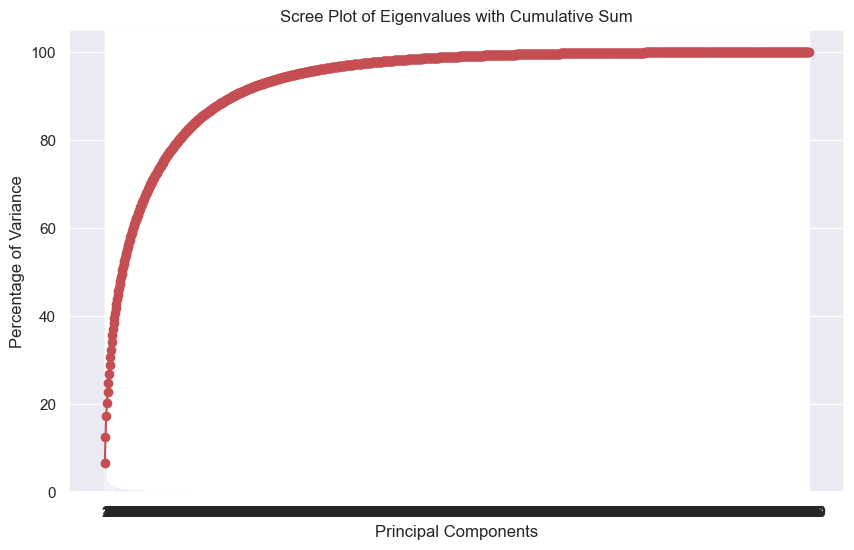

,Principal Components,Explained variance,% Explained Variance,% cum. Exp. Variance
0,PC1,7.878616e+00,7.0,7.0
1,PC2,6.971669e+00,6.0,13.0
2,PC3,5.610007e+00,5.0,17.0
3,PC4,3.435406e+00,3.0,20.0
4,PC5,3.012239e+00,3.0,23.0
...,...,...,...,...
1045,PC1046,3.824574e-32,0.0,100.0
1046,PC1047,3.824574e-32,0.0,100.0
1047,PC1048,3.824574e-32,0.0,100.0
1048,PC1049,3.106744e-32,0.0,100.0


In [49]:
exp_var_df = pd.DataFrame({
        "Principal Components" : ["PC" + str(x + 1) for x in range(1050)], 
        "Explained variance" : pca.explained_variance_,
        "% Explained Variance" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. Exp. Variance" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)})

# calculate explained variance and cumulative

explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = explained_variance.cumsum()

# show scree pmot

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r')
plt.title('Scree Plot of Eigenvalues with Cumulative Sum')
plt.xlabel('Principal Components')
plt.ylabel("Percentage of Variance")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()
display(exp_var_df)

In [50]:
# search 80% of cumulative explained variance

exp_var_df[exp_var_df['% cum. Exp. Variance'] == 80]

,Principal Components,Explained variance,% Explained Variance,% cum. Exp. Variance
108,PC109,0.222173,0.0,80.0
109,PC110,0.221485,0.0,80.0
110,PC111,0.218455,0.0,80.0
111,PC112,0.217628,0.0,80.0
112,PC113,0.216415,0.0,80.0


Avec 109 Composantes principales ont récupère 80% de la variance.

In [51]:
# execute PCA on the dense matrix X_bow_array

pca = PCA(n_components=109)
principal_components = pca.fit_transform(X_bow_array)

In [52]:
# create dataframe with columns name

pc_df = pd.DataFrame(principal_components, 
                     columns=["PC" + str(x + 1) for x in range(109)]
                    )

In [53]:
pc_df.shape

(1050, 109)

In [54]:
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109
0,3.334090,-2.275857,-2.980626,-1.596349,-2.767639,-1.118890,0.701947,0.793555,-0.859814,-1.931900,...,-0.688486,0.579538,-1.356090,-0.115072,0.152582,0.653021,0.912252,0.024216,-0.242937,0.749131
1,1.005027,-2.039240,-2.995659,0.051565,-0.755281,-0.896941,-0.279368,-0.783913,0.258801,-1.466827,...,-0.170783,-0.413211,0.034165,0.583905,-0.969461,0.120548,-0.228039,0.005989,0.108508,0.317500
2,2.788536,-3.852134,-4.749930,-0.624303,-0.442116,-1.745635,0.641104,-2.520498,1.296830,-1.618514,...,-1.678781,2.040591,-1.652104,0.204718,0.883955,-0.150074,-0.710126,-2.944038,1.683938,0.773725
3,3.469883,-4.401574,-5.807208,-1.097700,-1.305855,-4.670387,-2.008172,-9.716934,0.714471,0.989934,...,-0.313487,-1.351302,0.157745,1.014926,-0.863208,-0.831278,-1.222880,-0.174852,0.061550,-1.216980
4,4.701385,-6.062612,-7.118187,-1.415378,-1.503462,-5.592114,-1.731708,-11.482783,0.930163,2.222250,...,-0.042535,-1.090332,0.889315,-0.142572,0.627153,-0.282151,-0.962378,0.195018,0.248985,-0.923076


---
### 1.2.3 - KMeans sur les données réduites par ACP :

In [55]:
X_pca = pc_df.copy()

In [56]:
# features name list

features_list = pc_df.columns.tolist()

In [57]:
# standardscaler transformer

quantitative_transformer = Pipeline([("scaler", StandardScaler())])

# preprocessor pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("quant", quantitative_transformer, features_list),
    ]
)

In [66]:
# kmeans pipeline

pipeline_kmeans= Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "kmeans",
            KMeans(
                n_clusters=7, 
                init="k-means++", 
                n_init=1, 
                random_state=42),
        ),
    ]
)

In [67]:
# fit pipeline and time

start_time = time.time()
pipeline_kmeans.fit(X_pca)
end_time = time.time()
print("Clustering took {:.2f} s".format(end_time - start_time))

Clustering took 0.01 s


In [68]:
# retrieve cluster labels

cluster_labels = pipeline_kmeans.named_steps["kmeans"].labels_

### 1.2.4 - ACP en 2 CP et affichage graphique :

In [69]:
# pca 2D for viz

pca = PCA(n_components=2)
principal_components_kmeans = pca.fit_transform(X_bow_array)
principal_kmeans = pd.DataFrame(
    data=principal_components_kmeans, columns=["PC1", "PC2"]
)
principal_kmeans["cluster"] = cluster_labels

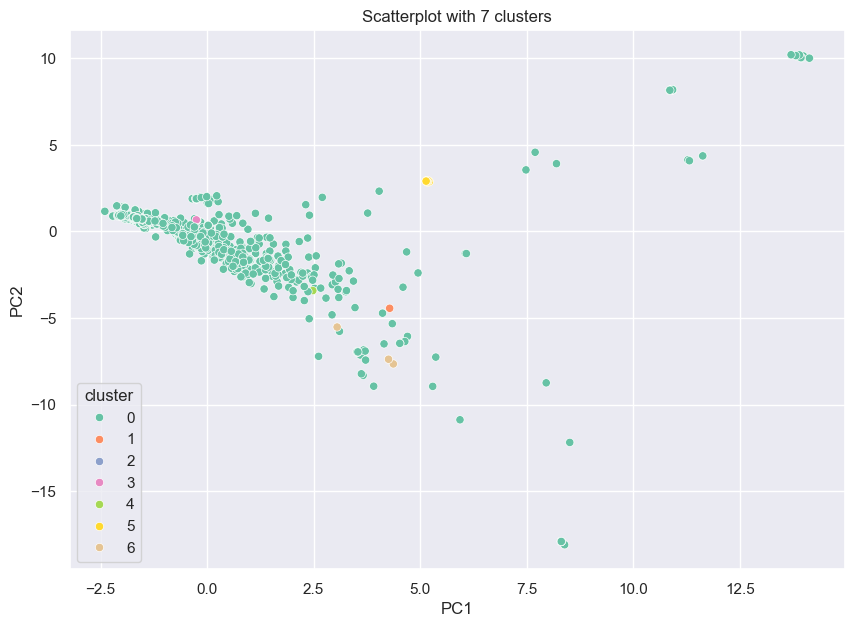

In [70]:
# scatterplot

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="cluster", 
    data=principal_kmeans, 
    palette=clusters_palette
)
plt.title(f"Scatterplot with 7 clusters")
plt.show()

In [71]:
# encoding original categories to calculate ARI

encoder = LabelEncoder()
true_labels_encoded = encoder.fit_transform(df['category'])

In [72]:
pred_labels = principal_kmeans["cluster"]

ari_score = adjusted_rand_score(true_labels_encoded, pred_labels)
print(f"ARI score for KMeans Model with PCA reduction on a BoW encoding : {round(ari_score,3)}")

ARI score for KMeans Model with PCA reduction on a BoW encoding : 0.002


**Commentaires :**  
* Graphique avec principalement des clusters 0 et 2
* Score ARI très faible à 0.002
* Approche non pertinente

---
### 1.2.4 - Réduction de dimensions par t-SNE :

In [73]:
# TSNE reduction

X_embedded = TSNE(n_components=2, 
                  learning_rate='auto', 
                  init='random', 
                  perplexity=30,
                  random_state=42
                 ).fit_transform(X_bow)

X_embedded.shape

(1050, 2)

In [74]:
# create dataframe with columns name

X_embedded = pd.DataFrame(
    data=X_embedded, columns=["TSNE1", "TSNE2"]
)

---
### 1.2.5 - KMeans sur les dimensions réduites par t-SNE :

In [75]:
features_list_tsne = X_embedded.columns.tolist()

In [76]:
# standardscaler transformer

quantitative_transformer = Pipeline([("scaler", StandardScaler())])

# preprocessor pipeline

preprocessor_tsne = ColumnTransformer(
    transformers=[
        ("quant", quantitative_transformer, features_list_tsne),
    ]
)

In [105]:
# kmeans pipeline

pipeline_tsne_kmeans= Pipeline(
    [
        ("preprocessor", preprocessor_tsne),
        (
            "kmeans",
            KMeans(
                n_clusters=7, 
                init="k-means++", 
                n_init=1, 
                random_state=42),
        ),
    ]
)

In [106]:
# fit pipeline and time

start_time = time.time()
pipeline_tsne_kmeans.fit(X_embedded)
end_time = time.time()
print("Clustering took {:.2f} s".format(end_time - start_time))

Clustering took 0.01 s


In [107]:
# retrieve cluster labels

tsne_cluster_labels = pipeline_tsne_kmeans.named_steps["kmeans"].labels_

In [108]:
# add labels to dataframe

tsne_clustering_df = X_embedded.copy()
tsne_clustering_df['cluster'] = tsne_cluster_labels

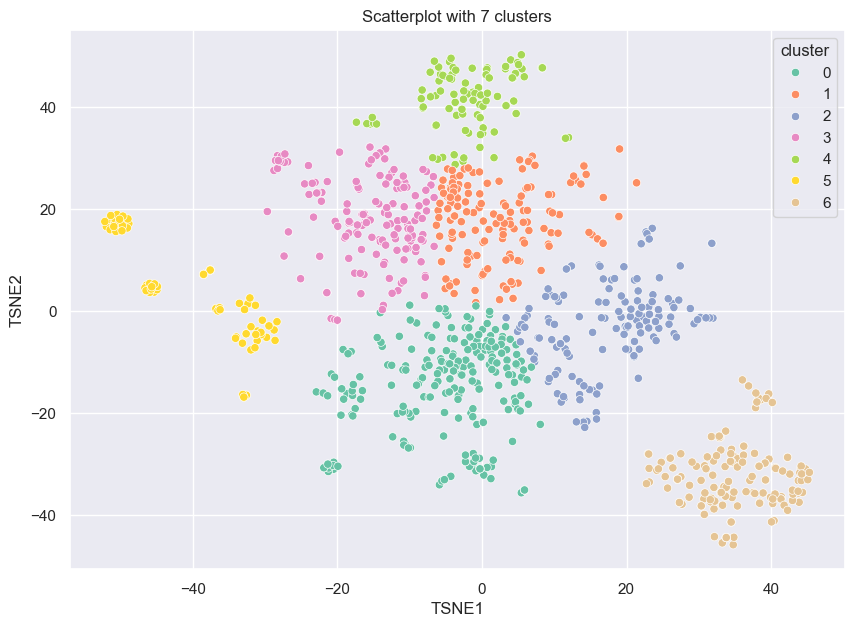

In [109]:
# scatterplot

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="TSNE1", 
    y="TSNE2", 
    hue="cluster", 
    data=tsne_clustering_df, 
    palette=clusters_palette
)
plt.title(f"Scatterplot with 7 clusters")
plt.show()

In [110]:
pred_labels = tsne_clustering_df["cluster"]

ari_score = adjusted_rand_score(true_labels_encoded, pred_labels)
print(f"ARI score for KMeans Model with Tsne reduction on a BoW encoding : {round(ari_score,3)}")

ARI score for KMeans Model with Tsne reduction on a BoW encoding : 0.423


**Commentaires :**  
* Répartition graphique des clusters plutôt homogène, groupée
* Score ARI meilleur qu'en ACP mais reste failble : 0.423

---
---
## 1.3 - Approche encodage **TF-Idf** :

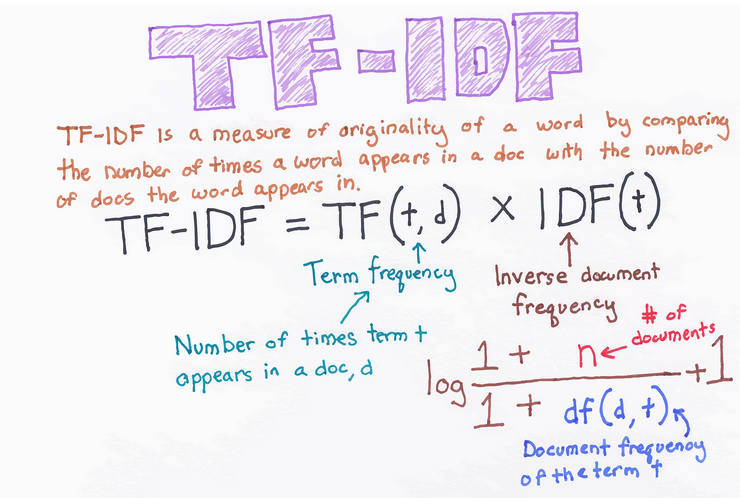

---
### 1.3.1 - Encodage TF-Idf :

**Stratégie :**  
1. Définition du corpus :  
       Utilisation de la colonne `token_desc`, créée précédemment avec nettoyage :  
      - Correction grammaire / orthographe
      - Tokenisation avec suppression de la ponctuation
      - Suppression des stopwords  
      - Suppression des custom_words (mots très fréquemment utilisés sans intérêt et les mots à fréquence = 1)  
      - Lémmatisation  
2. Encodage avec méthode TF-Idf
3. Réduction de dimension :
   - ACP :
        1. Détermination du nombre de CP pertinentes (80% de variance expliquée)
        2. Application ACP
        3. Classification par KMeans
        4. Réduction à 2 dimensions par ACP
        5. Affichage clustering
   - T-SNE :
        1. Réduction de dimension avec T-SNE
        2. Classification KMeans
        3. Affichage clustering
4. Conclusion de l'essai

In [83]:
# vectorizer instance

vectorizer = TfidfVectorizer()

In [84]:
X_tfidf = vectorizer.fit_transform(corpus)

In [85]:
# create dataframe with feature_names

tfidf_df = pd.DataFrame(X_tfidf.toarray(), 
                        columns=vectorizer.get_feature_names_out()
                       )
tfidf_df

,aa,aaa,abide,ability,able,abrasion,abroad,absolute,absorb,absorbency,...,zero,zika,zinc,zingalalaa,zip,zipper,zone,zoom,zora,ásatrú
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
### 1.3.2 - Réduction de dimensions par une ACP :

In [86]:
# convert sparse matrix to dense matrix

X_tfidf_array = X_tfidf.toarray()

In [87]:
# PCA fit_transform to dense matrix

pca = PCA()
principalComponents = pca.fit_transform(X_tfidf_array)

In [88]:
# show scree plot

#eigen_values = pca.explained_variance_
#plt.figure(figsize=(10, 7))
#plt.plot(range(1, len(eigen_values) + 1), eigen_values, marker='o')
#plt.xlabel('Components')
#plt.ylabel('Eigenvalues')
#plt.title('Scree Plot')
#plt.grid(True)
#plt.show()

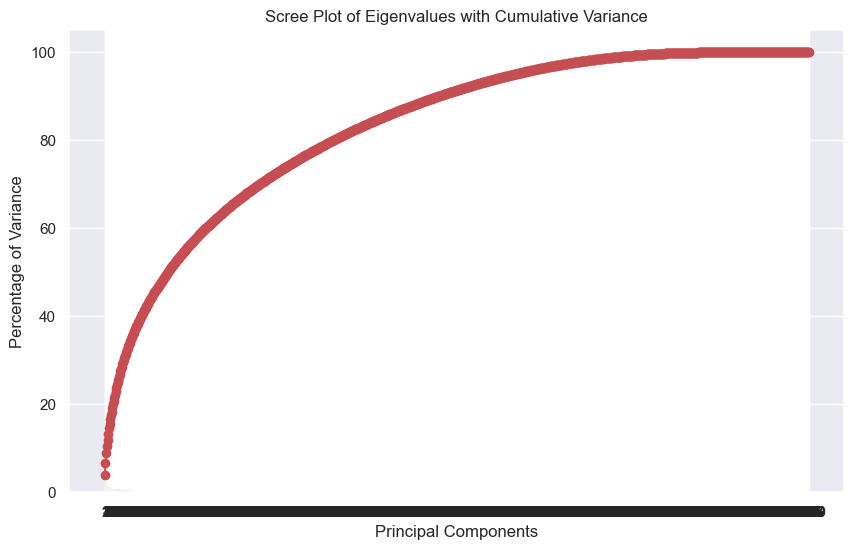

,Principal Components,Explained variance,% Explained Variance,% cum. Exp. Variance
0,PC1,3.776002e-02,4.0,4.0
1,PC2,2.521583e-02,3.0,7.0
2,PC3,2.353475e-02,2.0,9.0
3,PC4,1.480290e-02,2.0,11.0
4,PC5,1.361573e-02,1.0,12.0
...,...,...,...,...
1045,PC1046,2.851363e-34,0.0,100.0
1046,PC1047,2.777880e-34,0.0,100.0
1047,PC1048,2.722383e-34,0.0,100.0
1048,PC1049,2.609035e-34,0.0,100.0


In [89]:
exp_var_df = pd.DataFrame({
        "Principal Components" : ["PC" + str(x + 1) for x in range(1050)], 
        "Explained variance" : pca.explained_variance_,
        "% Explained Variance" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. Exp. Variance" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)})

# calculate explained variance and cumulative

explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = explained_variance.cumsum()

# show scree plot of eigenvalues and cumulative variance

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r')
plt.title('Scree Plot of Eigenvalues with Cumulative Variance')
plt.xlabel('Principal Components')
plt.ylabel("Percentage of Variance")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()
display(exp_var_df)

In [90]:
# search 80% of cumulative explained variance

exp_var_df[exp_var_df['% cum. Exp. Variance'] == 80]

,Principal Components,Explained variance,% Explained Variance,% cum. Exp. Variance
335,PC336,0.000766,0.0,80.0
336,PC337,0.000765,0.0,80.0
337,PC338,0.000762,0.0,80.0
338,PC339,0.000761,0.0,80.0
339,PC340,0.000760,0.0,80.0
340,PC341,0.000754,0.0,80.0
341,PC342,0.000754,0.0,80.0
342,PC343,0.000752,0.0,80.0
343,PC344,0.000750,0.0,80.0
344,PC345,0.000746,0.0,80.0


In [91]:
# execute PCA on dense matrix X_bow_array

pca = PCA(n_components=336)
principal_components = pca.fit_transform(X_tfidf_array)

In [92]:
# create dataframe with columns name

pc_df = pd.DataFrame(principal_components, columns=[
    "PC" + str(x + 1) for x in range(336)
])

In [93]:
pc_df.shape

(1050, 336)

In [94]:
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC327,PC328,PC329,PC330,PC331,PC332,PC333,PC334,PC335,PC336
0,-0.151540,0.051741,-0.064273,-0.202539,-0.064671,0.100093,-0.031547,-0.076817,0.315451,-0.053098,...,-0.037640,-0.017667,-0.016931,-0.007714,0.013456,0.035277,-0.002592,0.000004,0.016001,-0.012695
1,-0.124991,0.065351,-0.174086,-0.035913,-0.021859,0.122486,0.012186,0.639831,0.017651,0.007834,...,0.012659,0.015814,-0.017078,-0.001105,0.010591,-0.001036,0.016327,0.021917,-0.015864,-0.026876
2,-0.131087,0.055372,-0.133955,-0.042202,-0.026305,0.073103,0.011640,0.521966,-0.007728,0.026842,...,-0.002474,-0.006628,-0.023784,-0.001982,-0.028434,-0.021214,0.023092,0.047925,0.048239,0.060231
3,-0.159439,0.076727,-0.142229,-0.120699,-0.043043,0.083720,0.042434,0.039210,0.088298,0.002920,...,0.002507,-0.018555,-0.017106,-0.005891,0.005319,0.000632,0.020919,0.004400,-0.000282,-0.018840
4,-0.178644,0.080626,-0.154847,-0.128771,-0.052727,0.092795,0.061360,0.060207,0.084320,-0.002175,...,0.017380,-0.018628,-0.001598,-0.011725,-0.012231,-0.009875,0.000111,0.013108,0.004310,-0.010478


---
### 1.3.3 - KMeans sur les dimensions réduites par ACP : 

In [95]:
X_pca_tfidf = pc_df.copy()

In [96]:
# features name list

features_list_tfidf = X_pca_tfidf.columns.tolist()

In [97]:
# standardscaler transformer

quantitative_transformer = Pipeline([("scaler", StandardScaler())])

# preprocessor pipeline

preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ("quant", quantitative_transformer, features_list_tfidf),
    ]
)

In [99]:
# kmeans pipeline

pipeline_tfidf_kmeans = Pipeline(
    [
        ("preprocessor", preprocessor_tfidf),
        (
            "kmeans",
            KMeans(
                n_clusters=7, 
                init="k-means++", 
                n_init=1, 
                random_state=42),
        ),
    ]
)

In [100]:
# fit pipeline and time

start_time = time.time()
pipeline_tfidf_kmeans.fit(X_pca_tfidf)
end_time = time.time()
print("Clustering took {:.2f} s".format(end_time - start_time))

Clustering took 0.03 s


In [101]:
# retrieve cluster labels

cluster_labels_tfidf = pipeline_tfidf_kmeans.named_steps["kmeans"].labels_

In [102]:
# pca 2D for viz

pca = PCA(n_components=2)
principal_components_kmeans_tfidf = pca.fit_transform(X_tfidf_array)
principal_kmeans_tfidf = pd.DataFrame(
    data=principal_components_kmeans_tfidf, columns=["PC1", "PC2"]
)
principal_kmeans_tfidf["cluster"] = cluster_labels

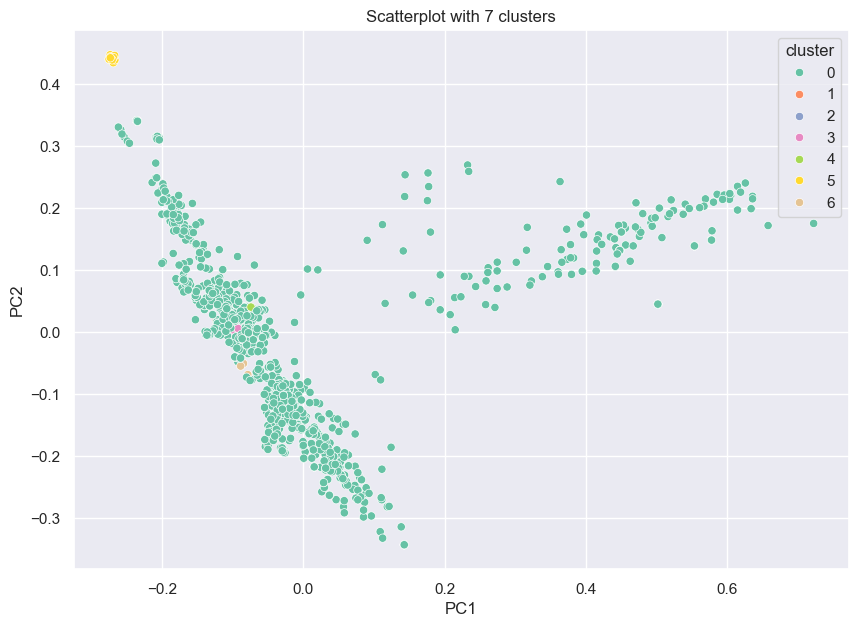

In [103]:
# scatterplot

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="cluster", 
    data=principal_kmeans_tfidf, 
    palette=clusters_palette
)
plt.title(f"Scatterplot with 7 clusters")
plt.show()

In [104]:
pred_labels = principal_kmeans_tfidf["cluster"]

ari_score = adjusted_rand_score(true_labels_encoded, pred_labels)
print(f"ARI score for KMeans Model with PCA reduction on a TF-Idf encoding : {round(ari_score,3)}")

ARI score for KMeans Model with PCA reduction on a TF-Idf encoding : 0.002


**Commentaires :**  
* Graphiquement les clusters 0 et 2 sont majoritaires, mélangés
* Le score ARI est très faible à : 0.002

---
### 1.3.4 - Réduction de dimensions par t-SNE :

In [111]:
# TSNE reduction

X_embedded_tfidf = TSNE(n_components=2, 
                        learning_rate='auto', 
                        init='random', 
                        perplexity=30,
                        random_state=42
                       ).fit_transform(X_tfidf)

In [112]:
X_embedded_tfidf.shape

(1050, 2)

In [114]:
# create dataframe 

df_embedded_tfidf = pd.DataFrame(
    data=X_embedded_tfidf, columns=["TSNE1", "TSNE2"]
)

In [115]:
# features name list

features_list_tsne_tfidf = df_embedded_tfidf.columns.tolist()

---
### 1.3.5 - KMeans sur les dimensions réduites par t-SNE :

In [116]:
# standardscaler transformer

quantitative_transformer = Pipeline([("scaler", StandardScaler())])

# preprocessor pipeline

preprocessor_tsne_tfidf = ColumnTransformer(
    transformers=[
        ("quant", quantitative_transformer, features_list_tsne_tfidf),
    ]
)

In [118]:
# kmeans pipeline

pipeline_tsne_tfidf_kmeans= Pipeline(
    [
        ("preprocessor", preprocessor_tsne_tfidf),
        (
            "kmeans",
            KMeans(
                n_clusters=7, 
                init="k-means++", 
                n_init=1, 
                random_state=42),
        ),
    ]
)

In [119]:
# fit pipeline and time

start_time = time.time()
pipeline_tsne_tfidf_kmeans.fit(df_embedded_tfidf)
end_time = time.time()
print("Clustering took {:.2f} s".format(end_time - start_time))

Clustering took 0.01 s


In [120]:
# retrieve cluster labels

tsne_tfidf_cluster_labels = pipeline_tsne_tfidf_kmeans.named_steps["kmeans"].labels_

In [121]:
# add labels to dataframe

tsne_tfidf_clustering_df = X_embedded.copy()
tsne_tfidf_clustering_df['cluster'] = tsne_tfidf_cluster_labels

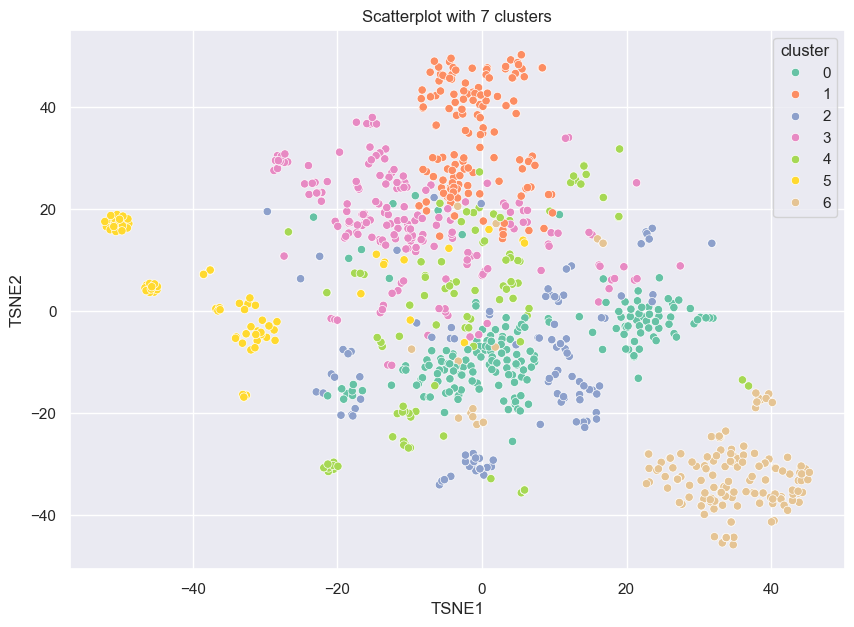

In [122]:
# scatterplot

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="TSNE1", 
    y="TSNE2", 
    hue="cluster", 
    data=tsne_tfidf_clustering_df, 
    palette=clusters_palette
)
plt.title(f"Scatterplot with 7 clusters")
plt.show()

In [123]:
pred_labels = tsne_tfidf_clustering_df["cluster"]

ari_score = adjusted_rand_score(true_labels_encoded, pred_labels)
print(f"ARI score for KMeans Model with Tsne reduction on a TF-Idf encoding : {round(ari_score,3)}")

ARI score for KMeans Model with Tsne reduction on a TF-Idf encoding : 0.426


**Commentaires :**  
* Graphiquement les clusters sont mélangés
* Score ARI meilleur qu'en PCA mais faible à 0.426

---
---
## 1.4 - Comparaison des clustering :

L'utilisation du ARI score comme métrique afin de comparer les clustering semble pertinent.

---
### 1.4.1 - Préparation d'un dataframe récapitulatif :

- Récupération de labels de 4 clustering :
    * **Bag of words** :  
          1. ACP KMeans  
          2. t-SNE KMeans  
    * **Tf-Idf** :  
          3. ACP KMeans  
          4. t-sne KMeans  

In [124]:
# create dataframe with original categories

temp_list = ['product_name', 'category']
df_labels_compare = df[temp_list].copy()

In [125]:
# add predict labels clustering

df_labels_compare['bow_acp_clusters'] = principal_kmeans['cluster']
df_labels_compare['bow_tsne_clusters'] = tsne_clustering_df['cluster']
df_labels_compare['tfidf_acp_clusters'] = principal_kmeans_tfidf['cluster']
df_labels_compare['tfidf_tsne_clusters'] = tsne_tfidf_clustering_df['cluster']

In [126]:
# show dataframe samples

df_labels_compare.sample(10)

,product_name,category,bow_acp_clusters,bow_tsne_clusters,tfidf_acp_clusters,tfidf_tsne_clusters
219,MCB Exports Mini 6 Drawer Chest Showpiece - ...,Home Decor & Festive Needs,0,1,0,3
402,Cinthol Deo Spray - Intense (Pack of 2) Combo Set,Beauty and Personal Care,0,0,0,0
429,"Smartpro 19.5v,3.9a Replacement Charger for Va...",Computers,0,0,0,4
109,Remtex Export Cartoon Single Dohar Multicolor,Home Furnishing,0,3,0,3
579,Timewel 1100-N31 Analog Watch - For Men,Watches,0,6,0,6
317,Archies VJ-552 Combo Set,Beauty and Personal Care,0,0,0,0
878,Woven Terry Cotton Bath Towel,Home Furnishing,0,1,0,1
989,Kaatru Surya Bhagavan Showpiece - 23.5 cm,Home Decor & Festive Needs,0,2,0,0
464,Fs Mini Klub Baby Girl's Fit and Flare Dress,Baby Care,0,4,0,1
173,Rockmantra Water Fire Ceramic Mug,Kitchen & Dining,5,5,5,5


In [127]:
df_labels_compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_name         1050 non-null   object
 1   category             1050 non-null   object
 2   bow_acp_clusters     1050 non-null   int32 
 3   bow_tsne_clusters    1050 non-null   int32 
 4   tfidf_acp_clusters   1050 non-null   int32 
 5   tfidf_tsne_clusters  1050 non-null   int32 
dtypes: int32(4), object(2)
memory usage: 32.9+ KB


---
### 1.4.2 - Calcul du ARI score :

In [128]:
# loop to calculate ARI score

clustering_columns = ['bow_acp_clusters', 
                      'bow_tsne_clusters', 
                      'tfidf_acp_clusters', 
                      'tfidf_tsne_clusters'
                     ]

for col in clustering_columns:
    pred_labels = df_labels_compare[col]  
    ari_score = adjusted_rand_score(true_labels_encoded, pred_labels)
    print(f"ARI score for {col}: {round(ari_score,3)}")

ARI score for bow_acp_clusters: 0.002
ARI score for bow_tsne_clusters: 0.423
ARI score for tfidf_acp_clusters: 0.002
ARI score for tfidf_tsne_clusters: 0.426


**Commentaires :**  
- Entre les méthodes d'encodage : BoW et Tf-IDF, on retrouve des scores ARI très proches (avec les mêmes réductions)
- Sur les réductions de dimensions, l'ACP est clairement en dessous le Tsne.
- Meilleur score ARI pour le BoW avec réduction par Tsne. 


---
---
---
# Etape 2 : Etudiez la faisabilité de classification en utilisant des techniques NLP plus avancées :

Après l'étude de faisabilité en utilisant des méthodes basiques, il est intéressant de se diriger vers des méthodes plus avancées, notamment le **Word Embedding** avec son approche par vecteurs qui va plus loin en capturant le contexte des mots, voir des phrases complètes.  
En premier lieu, un modèle simple basé sur **Word2Vec** sera testé sur un réseau de neurones à 1 couche d'embeddings. Ensuite une évaluation des modèles pré-entrainés plus complexes basés sur l'architecture Transformers BERT seront testés sur différents **Frameworks** (PyTorch, TensorFlow et TensorFlow Hub) afin d'essayer de capturer les relations entre les mots dans les phrases complètes. Une dernière approche sera testée sur un autre modèle pré-entrainé : **USE**, qui génère des embeddings de phrases et non plus de mots.


**Algorithmes de Word Embeddings utilisés :**  
1. Word2Vec :
3. BERT (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers)
4. USE (**U**niversal **S**entence **E**ncoder)

##### Fonctions

In [142]:
def ARI_and_TSNE(embeddings, y_true):
    """"""

    labels_pred = KMeans(n_clusters=7, random_state=22).fit_predict(embeddings)
    ari = adjusted_rand_score(y_true, labels_pred)
    
    # TSNE reduction

    X_tsne = TSNE(n_components=2, 
                        learning_rate='auto', 
                        init='random', 
                        perplexity=30,
                        random_state=42
                       ).fit_transform(embeddings)

    df_tsne = pd.DataFrame(data=X_tsne, columns=["TSNE_1", "TSNE_2"])
    df_tsne['cluster'] = labels_pred
    return ari, df_tsne

def visualize_tsne(df_tsne, y_true, ari_score):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x="TSNE_1", 
        y="TSNE_2", 
        hue="cluster", 
        data=df_tsne, 
        palette=clusters_palette
    )
    plt.title(f"Visualization of t-SNE Clusters (ARI: {ari_score:.4f})")
    plt.show()

#####  

---
## 2.1 - Algorithme Word2Vec :

**Stratégie :**
1. Nettoyage avec :
    - Correction grammaire/orthographe
    - Tokenisation sans ponctuation
    - Mise en minuscule
    - Suppression stopwords
    - Lémmatisation
2. Configuration et entrainement d'un modèle Word2Vec (représentation vectorielle par mot)
3. Préparation des données avec tokénisation et padding
4. Création de la matrice d'embeddings (vecteurs par mot)
5. Création d'un modèle de réseau de neurones avec 1 couche d'embeddings (matrice d'embeddings)
6. Prédiction du réseau de neurones avec en entrée, les données préparées (4.)
7. Réduction par Tsne, Kmeans et visualisation + Score ARI

In [143]:
# cleaning function for Word2Vec method

def preprocessing_doc(text):
    """perform cleaning function with parameters"""

    new_doc = cleaning_process(text,  
                               stop_words,
                               lemmatization=True,
                               rejoin=True
                              )
    return new_doc

df['tokens_w2v'] = df.description.parallel_apply(preprocessing_doc)

In [144]:
# variables

#sentences = df['tokens_w2v']
w2v_size = 300
maxlen = 40

In [145]:
sentences = df['tokens_w2v']
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

Entrainement du modèle afin qu'il apprenne les représentations vectorielles pour chaque mot.

In [146]:
# train model

print("Build & train Word2Vec model ...")
begin = time.time()

w2v_model = gensim.models.Word2Vec(sentences=sentences, 
                     vector_size=w2v_size, 
                     window=5, 
                     min_count=1, 
                     sg=0, 
                     epochs=100, 
                     seed=42, 
                     workers=8
                    )

end = time.time()
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print(f"Word2Vec trained in {round(end - begin,1)} s.")

Build & train Word2Vec model ...
Vocabulary size: 3866
Word2Vec trained in 2.6 s.


Tokenisation et ajout de zéro afin de remplir les lignes

In [147]:
# tokenization an padding

keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(keras_tokenizer.texts_to_sequences(sentences), 
                            maxlen=maxlen, 
                           padding='post'
                           )

Création de la matrice d'embeddings (matrice des vecteurs par mot)

In [148]:
# create embedding matrix

vocab_size = len(keras_tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))

for word, idx in keras_tokenizer.word_index.items():
    if word in model_vectors:
        embedding_matrix[idx] = model_vectors[word]

print(f"Word embedding rate: {np.round(np.mean(embedding_matrix.sum(axis=1) > 0), 4)}")
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Word embedding rate: 0.293
Embedding matrix shape: (3867, 300)


Création d'un modèle dans un réseau de neurones avec 1 couche d'embeddings qui utilise la matrice créée précédemment.

In [149]:
# construct embedding model

word_input = Input(shape=(maxlen,))
word_embedding = Embedding(input_dim=vocab_size, 
                          output_dim=w2v_size, 
                          weights=[embedding_matrix], 
                          trainable=True)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model(inputs=word_input, outputs=word_vec)

embed_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 40, 300)        │     1,160,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160,100 (4.43 MB)

 Trainable params: 1,160,100 (4.43 MB)

 Non-trainable params: 0 (0.00 B)

Prédictions du réseau de neurones du jeu de données tokénisé précédemment.

In [150]:
# generate embedding sentences

begin = time.time()

embeddings = embed_model.predict(x_sentences)

end = time.time()
print(f"It takes : {round(end - begin, 2)} s")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
It takes : 0.11 s


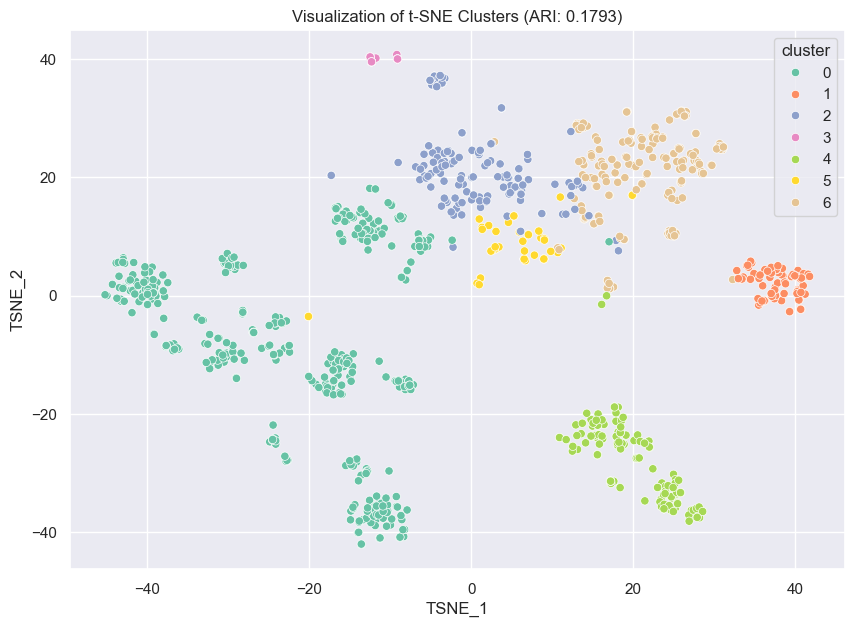

In [151]:
ARI_score_w2v, df_w2v = ARI_and_TSNE(embeddings, true_labels_encoded)
visualize_tsne(df_w2v, true_labels_encoded, ARI_score_w2v)

In [152]:
print(f"ARI score for KMeans Model with Tsne reduction on Word2Vec encoding : {round(ARI_score_w2v,3)}")

ARI score for KMeans Model with Tsne reduction on Word2Vec encoding : 0.179


**Commentaires :**  
* Graphiquement les clusters sont plutôt bien groupés sur eux-même et distants
* Score ARI faible à 0.179

---
---
## 2.2 - Algorithmes BERT :

##### Fonctions :

In [153]:
def tokenize_texts(texts, tokenizer, max_length=128, framework="pt"):
    """ generic tokenize function pt or tf """
    return tokenizer(
        texts,
        padding=True,                
        truncation=True,             
        max_length=max_length,      
        return_tensors=framework,
        
    )

def extract_features(model, tokenizer, df, column='description', 
                     batch_size=2, framework='pt', 
                     use_tf_hub=False, preprocessor=None):
    """
    generic function for BERT models from Transformers or TensorFlow Hub
    Args:
    -model : BERT model (pt, tf or tf hub)
    -tokenizer : tokenizer model
    -df : dataframe
    -column : column name in the dataframe with text
    -batch_size : size of the batch to process
    -framework : 'pt' for PyTorch or 'tf' for TensorFlow
    -use_tf_hub : if True, the model comes from TensorFlow Hub
    -preprocessor : reprocessor layer from tf hub
    Return:
    -features : matrix of meaning texts
    """
    
    features = []

    begin = time.time()
    
    # loop through batches
    for i in range(0, len(df), batch_size):
        batch_texts = df[column][i:i + batch_size].tolist()
        
        if use_tf_hub:
            # tf hub model and preprocessor
            if preprocessor is None:
                raise ValueError("For TensorFlow Hub models, the preprocessor must be provided.")
                    
            # preprocessor
            inputs = preprocessor(batch_texts)
            
            # tf hub model
            outputs = model(inputs)

            # last hidden states
            last_hidden_states = outputs['sequence_output']
            
            # mean
            batch_features = tf.reduce_mean(last_hidden_states, axis=1).numpy()
        else:
            
            # tokenize batch 
            inputs = tokenize_texts(batch_texts, tokenizer, framework=framework)
            
            if framework == 'pt':
                
                # pt model
                with torch.no_grad():
                    outputs = model(**inputs)
                    last_hidden_states = outputs.last_hidden_state
                    
                    batch_features = last_hidden_states.mean(dim=1).cpu().numpy()
                
            elif framework == 'tf':
                
                # tf model
                outputs = model(inputs['input_ids'], 
                                attention_mask=inputs['attention_mask'], 
                                token_type_ids=inputs.get('token_type_ids', None)
                               )
                end = time.time()
                last_hidden_states = outputs.last_hidden_state

                # mean
                batch_features = tf.reduce_mean(last_hidden_states, axis=1).numpy()
        
        # add batch features
        features.append(batch_features)
    
    # concatenate all batch features into matrix
    features = np.vstack(features)
    end = time.time()
    
    print(f'Modelisation take : {round(end - begin, 2)} s')
    return features

def feature_USE_fct(df, column='description', batch_size=2) :
    batch_size = batch_size
    begin = time.time()

    #features = []
    
    for i in range(0, len(df), batch_size):
        batch_texts = df[column][i:i + batch_size].tolist()

        feat = use_model(batch_texts)
        if i ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    end = time.time()

    print(f'Modelisation take : {round(end - begin, 2)} s')
    return features


#####  

**Frameworks utilisés :**
* Pytorch (AutoTokenizer + BertModel pretrained:**bert-base-uncased** )
* TensorFlow (BertTokenizer + TFBertModel pretrained:**bert-base-uncased**)
* TensorFlow Hub (bert_en_uncased_preprocess + bert_en_uncased_L-12_H-768_A-12/3)

---
### 2.2.1 - Framework : Pytorch

In [154]:
# Pytorch Model

model_name = 'bert-base-uncased'
model_pt = BertModel.from_pretrained(model_name)
tokenizer_pt = AutoTokenizer.from_pretrained(model_name)

features_pt = extract_features(model_pt, 
                               tokenizer_pt, 
                               df, 
                               column='description', 
                               batch_size=2, 
                               framework='pt'
                              )

/home/garth/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Modelisation take : 44.81 s


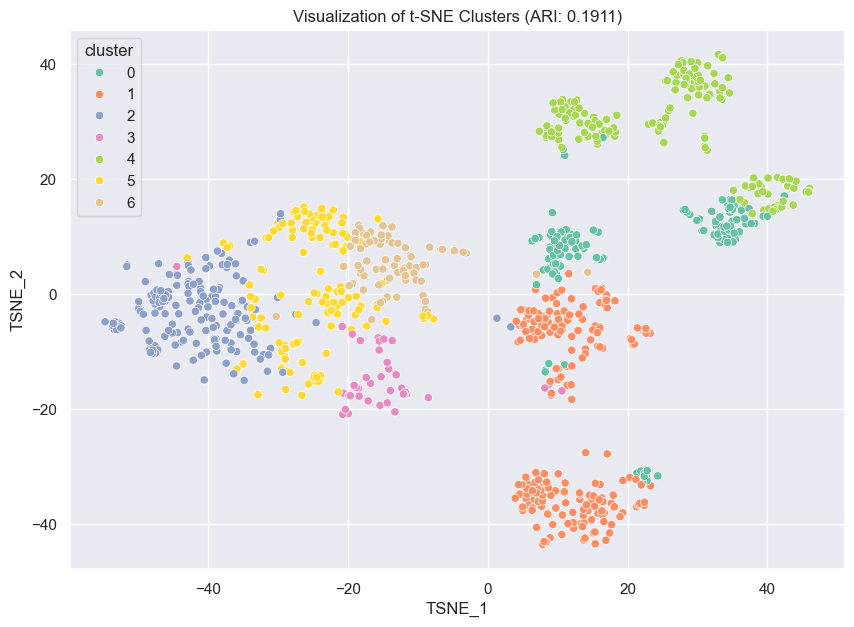

In [155]:
ARI_score_pt, df_tsne_pt = ARI_and_TSNE(features_pt, true_labels_encoded)
visualize_tsne(df_tsne_pt, true_labels_encoded, ARI_score_pt)

In [156]:
print(f"ARI score for KMeans Model with Tsne reduction on BERT Pytorch encoding : {round(ARI_score_pt,3)}")

ARI score for KMeans Model with Tsne reduction on BERT Pytorch encoding : 0.191


**Commentaires :**
* Graphique : des mélanges de clusters
* Score ARI faible à 0.191

---
### 2.2.2 - Framework : TensorFlow

In [157]:
# tf model

model_name = 'bert-base-uncased'
model_tf = TFBertModel.from_pretrained(model_name)
tokenizer_tf = BertTokenizer.from_pretrained(model_name)

features_tf = extract_features(model_tf, 
                               tokenizer_tf, 
                               df, 
                               column='description', 
                               batch_size=2, 
                               framework='tf'
                              )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Modelisation take : 140.61 s


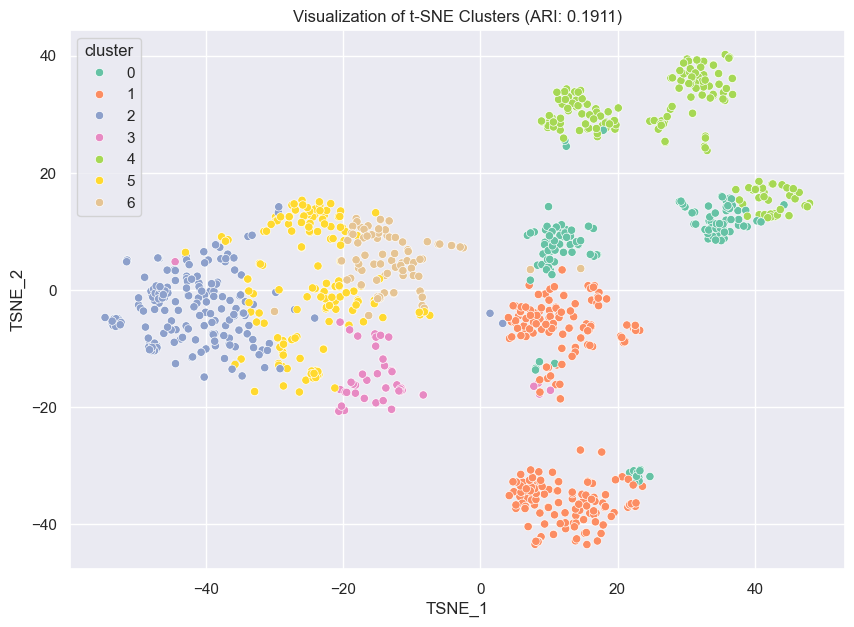

In [158]:
ARI_score_tf, df_tsne_tf = ARI_and_TSNE(features_tf, true_labels_encoded)
visualize_tsne(df_tsne_tf, true_labels_encoded, ARI_score_tf)

In [159]:
print(f"ARI score for KMeans Model with Tsne reduction on BERT TensorFlow encoding : {round(ARI_score_tf,3)}")

ARI score for KMeans Model with Tsne reduction on BERT TensorFlow encoding : 0.191


**Commentaires :**
* Graphique : des mélanges de clusters
* Score ARI faible à 0.191

---
### 2.2.3 - Framework : TensorFlow Hub

In [160]:
bert_model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3" 

In [161]:
bert_model = hub.KerasLayer(bert_model_url, trainable=False)
bert_preprocessor = hub.KerasLayer(preprocessor_url)

In [162]:
features_hub = extract_features(bert_model, 
                                None, 
                                df, 
                                column='description', 
                                batch_size=2, 
                                framework='tf', 
                                use_tf_hub=True, 
                                preprocessor=bert_preprocessor
                               )

Modelisation take : 119.83 s


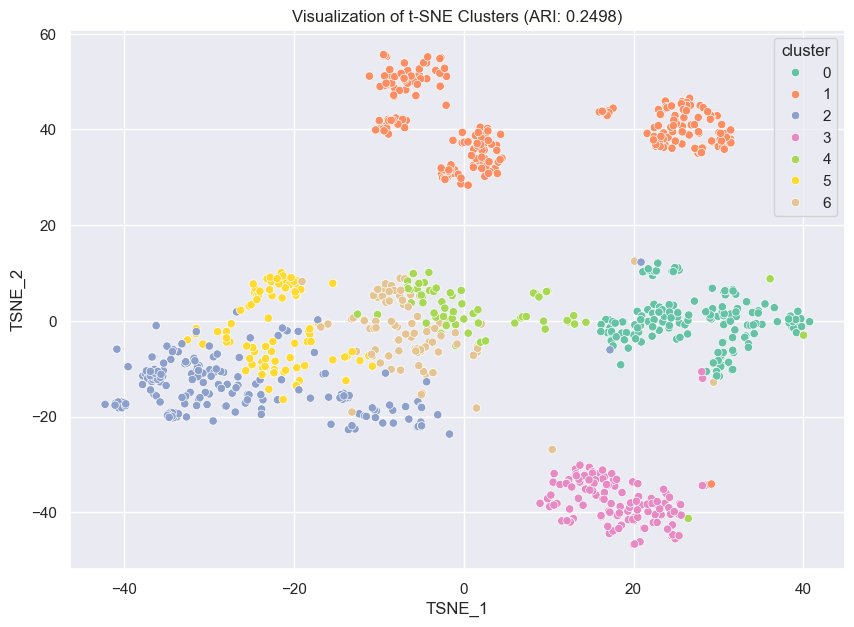

In [163]:
ARI_score_hub, df_tsne_hub = ARI_and_TSNE(features_hub, true_labels_encoded)
visualize_tsne(df_tsne_hub, true_labels_encoded, ARI_score_hub)

In [164]:
print(f"ARI score for KMeans Model with Tsne reduction on BERT TensorFlow Hub encoding : {round(ARI_score_hub,3)}")

ARI score for KMeans Model with Tsne reduction on BERT TensorFlow Hub encoding : 0.25


**Commentaires :**
* Graphique : légers mélanges entre certains clusters
* Score ARI faible à 0.25

---
---
## 2.3 - Méthode USE :

In [165]:
use_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.KerasLayer(use_model_url)

In [166]:
features_USE = feature_USE_fct(df, column='description', batch_size=2)

Modelisation take : 1.4 s


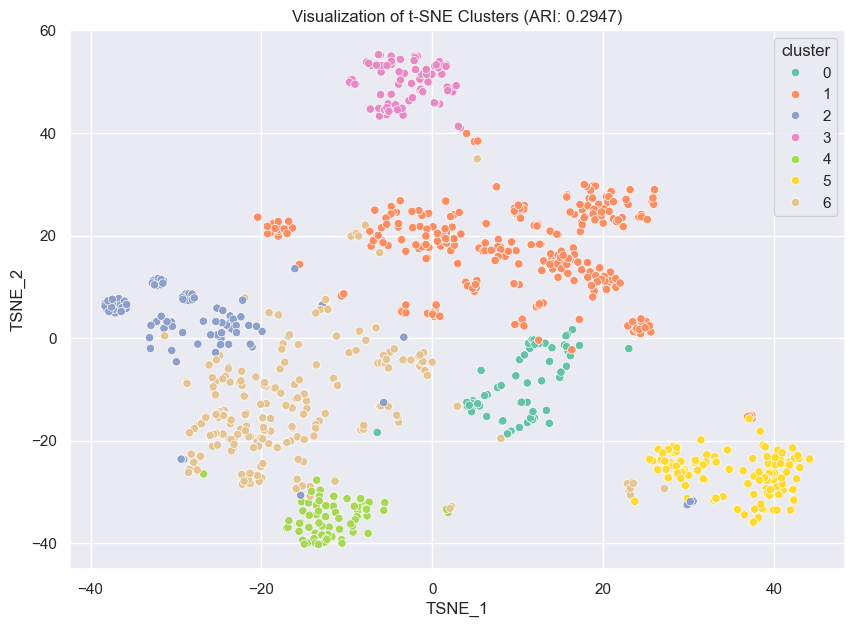

In [167]:
ARI_score_use, df_tsne_use = ARI_and_TSNE(features_USE, true_labels_encoded)
visualize_tsne(df_tsne_use, true_labels_encoded, ARI_score_use)

In [168]:
print(f"ARI score for KMeans Model with Tsne reduction on USE encoding : {round(ARI_score_use,3)}")

ARI score for KMeans Model with Tsne reduction on USE encoding : 0.295


**Commentaires :**
* Graphique : légers mélanges entre certains clusters
* Score ARI faible à 0.295

---
---
### 2.4 - Récapitulatif :

| Encoding               | ARI score |
|------------------------|-----------|
| BoW PCA                | 0.084     |
| BoW Tsne               | 0.389     |
| TF-Idf PA              | 0.084     |
| TF-IDF Tsne            | 0.356     |
| Word2Vec               | 0.183     |
| BERT Pytorch           | 0.191     |
| BERT TensorFlow        | 0.191     |
| BERT TensorFlow Hub    | 0.25      |
| USE                    | 0.295     |


Avec notre dataset, la méthode Bag Of Words avec une réduction de dimension grâce à Tsne donne les meilleurs résultats.  
Toutefois nous sommes sur un score ARI faible à 0.389